# Capstone Project - Analysis of the Corona pandemic
In this project, the data from the ongoing "Corona" pandemic is analyzed. The SARS-CoV-2 virus has spread around the world in a relatively short time after its first apperance in Wuhan (China) and the caused disease COVID-19 (=coronavirus disease 2019) stresses the healthcare systems in many countries. Here it is analyzed what are the driving forces for the exponential growths rates and how effective are the measures against.

Therefor, two datasets are analyzed:

1. One dataset has been taken from the CSSE at Johns Hopkins University: It shows timeseries regarding cumulative Corona cases of all affacted countries. The data has been taken from the following GitHub repository. Please note, that the data is updated every day. Thus, there might be effects on the conclusion in a few weeks. For this analysis, data taken on April 14th has been used (stored in DataScience_Project4 GitHub): https://github.com/CSSEGISandData/COVID-19/edit/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

2. Another dataset has been downloaded from Kaggle. It gives an overview on different Corona-related information for the affected countries: https://www.kaggle.com/koryto/countryinfo#covid19countryinfo.csv

## 1. Questions
The main questions are:
1. What are the effects of the initial situation in the different countries on the exponential growth rate?
2. What are the effects of the different measures to contain the disease?

To answer these questions, it is - after a general data understanding - checked for correlations between measures in the data. In a second step it is checked whether it is possible to predict growth and containment.


## 2. Data understanding
The data is loaded and a number of things are checked to understand the datasets.


In [58]:
# Import standard packages
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

# Import additional packages
from scipy.signal import savgol_filter # Implements specific filter (Savitzky-Golay) to smooth statistical fluctuations
from scipy.signal import medfilt # Implements median filter
from datetime import date
import math
import capstone_support_functions as capstone

# Import helper functions stored in 

# Set output options in a way that all columns and rows of the used datasets are visible
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 1000)

df_timeseries = pd.read_csv('./time_series_covid19_confirmed_global.csv') # Read in timeseries data
df_countryinfo = pd.read_csv('./covid19countryinfo.csv') # Read in country information data

#df_tests = pd.read_csv('./covid19tests.csv') # Read in data

### Check the timeseries data

In [2]:
# Show the timeseries data
df_timeseries.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7,7,7,7,9,15,15,15,15,19,19,19,19,21,21,23,23
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265,1451,1451,1554,1628,1715,1795,1975,1975,2142,2208,2277
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736,770,822,833,853,881,921,937,967,1013,1039,1067
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77,78,80,84,87,91,93,96,96,96,99,100,103,103,103,102,103
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389,2493,2580,2637,2686,2734,2773,2822,2857,2857,2863,2870


In [3]:
print('The dataset contains', df_timeseries.shape[0], 'rows and', df_timeseries.shape[1], 'columns.')

The dataset contains 264 rows and 88 columns.


In [4]:
df_timeseries['Country/Region'].value_counts()

China                               33
Canada                              15
United Kingdom                      11
France                              11
Australia                            8
Netherlands                          5
Denmark                              3
Estonia                              1
Czechia                              1
Gabon                                1
Holy See                             1
Maldives                             1
Kyrgyzstan                           1
Tunisia                              1
Egypt                                1
Georgia                              1
Afghanistan                          1
Saudi Arabia                         1
Brazil                               1
Chile                                1
Senegal                              1
Trinidad and Tobago                  1
Bulgaria                             1
Korea, South                         1
Saint Lucia                          1
Belize                   

The timeseries contains the number of Corona cases for 258 countries/regions for a time period beginning on January 22, 2020. In some cases, there is a differentiation between different provinces/states of a country, e.g. 33 different ones for China. Furthermore, the latitutde and longitude of the countries are shown.

In the next step, the number of cases are plotted. Thereby, the countries with the highest number of cases at the end of the timeseries are shown. Before, the functionality is implemented into a function which will be reused later.

In [5]:
def visualize_timeseries(df, logy_scale):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    number_of_top_countries - Number of countries with the highest number of cases which are visualized
    
    Description:
    The input timeseries is visualized with a line chart
    '''

    # Remove nan values
    df['Province/State'].fillna("", inplace=True)

    # Add a column country that combines Country/Region and Province/State
    df['Country']=df['Country/Region']+" "+df['Province/State']

    # Define the country column as the new index (later on shown in the plot legend)
    df.set_index('Country', inplace=True)

    # Delete columns which are not needed for the plot
    del df['Country/Region']
    del df['Province/State']
    del df['Lat']
    del df['Long']
    if 'Infections' in df:
        del df['Infections']
    if 'Outbreak_Start' in df:
        del df['Outbreak_Start']
        
    # Exchange rows and columns which is required for the plot function (in line charts columns are plotted)
    df=df.transpose()
    
    # Create plot
    plt.style.use('seaborn') # Define style  
    df.plot(kind='line', legend=True, logy=logy_scale, mark_right=True)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # Show legend outside of the plot
    plt.show()

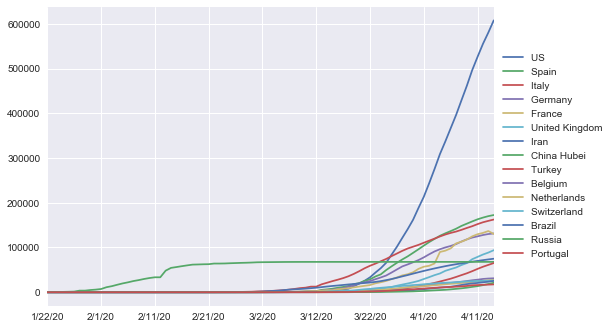

In [6]:
# Visualize the 15 countries with the highest number of infections (sorted ascendingly and select top 15)
visualize_timeseries(df_timeseries.sort_values(by=df_timeseries.columns[-1], ascending=False).head(15), False)

The plot above shows the typical chart maybe known from news coverage. It shows typical exponential growth curves for most of the countries. After some days, the growth seems to change to a more linear growth. Two curves have a very specific shape. The US curves shows the highest growth rate while for China the growth has stopped after a second steep increase mid of February.

### Check the country information data

In [7]:
# Show countryinfo
df_countryinfo.head(20)

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,publicplace,gatheringlimit,gathering,nonessential,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity,firstcase,totalcases,active30,active31,active1,active2,active3,newcases30,newcases31,newcases1,newcases2,newcases3,deaths,newdeaths30,newdeaths31,newdeaths1,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m
0,NaN,Afghanistan,AFG,AF,"38,928,346",NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333,2/23/2020,273,139,165,187,225,257,25,4,22,2,NaN,6,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,7,0.20
1,NaN,Albania,ALB,AL,"2,877,797",NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9,29.40,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04,"15,418",774,268.955733,1.51,13.950000,69.900000,3/7/2020,304,168,176,177,194,199,11,20,16,18,27,16,1.0,4.0,NaN,1.0,NaN,89,7,8,7,7,7,106,6.00
2,NaN,Algeria,DZA,DZ,"43,851,044",NaN,NaN,18.0,29.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,1.9,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81,"172,781","1,031",23.511413,2.70,19.566667,61.716667,2/24/2020,986,449,626,728,728,839,NaN,132,131,NaN,NaN,86,NaN,9.0,14.0,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,22,2.00
3,NaN,Andorra,AND,AD,"77,265",NaN,NaN,164.0,45.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5,32.50,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN,"91,527","5,949",76994.758300,1.40,7.383333,75.233333,3/1/2020,439,322,352,366,403,407,NaN,NaN,14,38,11,16,NaN,NaN,2.0,1.0,1.0,16,10,10,12,12,12,"5,682",207.00
4,NaN,Antigua and Barbuda,ATG,AG,"97,929",NaN,NaN,223.0,34.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78,"1,688","1,105",11283.685120,2.00,NaN,NaN,3/12/2020,9,7,7,7,7,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,NaN
5,NaN,Argentina,ARG,AR,"45,195,774",NaN,NaN,17.0,32.0,93.0,3/20/2020,NaN,NaN,NaN,NaN,NaN,5.0,23.95,1.05,1.06,1.05,1.00,0.94,0.71,0.98,29.27,20.16,42.59,"445,469","1,390",30.755088,2.26,32.816667,43.616667,3/2/2020,"1,265",570,700,778,851,970,NaN,146,NaN,NaN,NaN,39,2.0,3.0,1.0,2.0,3.0,256,NaN,NaN,NaN,NaN,NaN,28,0.90
6,NaN,Armenia,ARM,AM,"2,963,243",694.0,4269.802594,104.0,35.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,4.2,26.90,1.13,1.14,1.06,0.93,0.84,0.67,0.94,23.86,16.17,35.99,"13,444",883,297.984337,1.64,7.100000,58.500000,2/29/2020,736,449,499,536,625,686,58,50,39,92,73,7,NaN,NaN,1.0,1.0,NaN,43,15,30,30,30,30,248,2.00
7,Aruba,Netherlands,ABW,AW,"106,766",NaN,NaN,593.0,41.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,1.02,1.01,1.01,0.93,0.87,0.64,0.90,NaN,NaN,NaN,"2,903",43,402.749939,1.83,26.533333,80.166667,3/12/2020,60,49,54,54,54,59,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,562,NaN
8,NaN,Australia,AUS,AU,"25,499,884",31635.0,806.065560,3.0,38.0,86.0,NaN,NaN,3/23/2020,2.0,3/29/2020,NaN,3.8,14.90,1.06,1.06,1.09,0.99,0.93,0.86,0.99,18.79,15.90,22.16,"1,376,255","4,492",176.157664,1.77,25.783333,64.233333,1/24/2020,"5,350","3,983","4,205","4,498","4,767","4,737",82,101,101,89,36,28,1.0,NaN,1.0,2.0,3.0,585,28,28,50,50,85,210,1.00
9,NaN,Austria,AUT,AT,"9,006,398",10278.0,876.279237,109.0,43.0,57.0,3/16/2020,NaN,NaN,NaN,NaN,NaN,7.6,35.15,1.05,1.05,1.04,1.00,0.98,0.76,0.96,17.02,13.02,22.14,"447,718","5,138",570.483339,1.47,9.466667,65.350000,2/24/2020,"11,444","8,710","8,886","9,003","9,120","9,254",666,491,405,316,315,168,22.0,20.0,18.0,12.0,10.0,"2,022",193,198,215,227,245,"1,271",19.00


In [8]:
# Get an overview on the dataset
df_countryinfo.describe()

,tests,testpop,density,medianage,urbanpop,gatheringlimit,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,healthperpop,fertility,avgtemp,avghumidity,newdeaths30,newdeaths31,newdeaths1,newdeaths2,newdeaths3,deathdiv1m
count,52.000000,52.000000,187.000000,187.000000,187.000000,32.000000,186.000000,123.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,186.000000,164.000000,164.000000,164.000000,183.000000,185.000000,152.000000,152.000000,56.000000,66.000000,68.000000,67.000000,56.000000,135.000000
mean,30192.903846,22281.534633,412.743316,32.084492,64.087166,98.281250,3.299401,21.986992,1.051390,1.045989,1.050107,1.043422,0.959679,0.796952,1.007204,24.505549,18.920122,32.088841,2355.124042,2.482649,19.312829,67.653838,22.910714,52.651515,47.617647,45.477612,45.767857,18.720593
std,65479.055781,67986.836475,2083.936842,9.455375,22.164482,218.532973,2.806039,9.005344,0.026664,0.030311,0.133025,0.345960,0.261363,0.155203,0.207092,15.475574,13.932863,19.537331,11877.522514,1.221939,10.899411,14.499465,76.898818,146.624113,140.513348,139.384291,135.124991,83.240696
min,500.000000,35.588092,0.000000,15.200000,15.000000,2.000000,0.100000,3.700000,0.940000,0.970000,0.830000,0.710000,0.580000,0.450000,0.840000,6.290000,0.690000,9.210000,0.172463,0.200000,-9.883333,10.983333,1.000000,1.000000,1.000000,1.000000,1.000000,0.010000
25%,1505.500000,794.582044,35.500000,24.700000,46.500000,10.000000,1.300000,15.150000,1.035000,1.030000,1.010000,0.970000,0.870000,0.715000,0.960000,16.320000,10.902500,21.540000,11.883978,1.690000,9.708333,62.200000,1.000000,1.000000,1.000000,2.000000,1.000000,0.300000
50%,5950.000000,2811.814632,94.000000,32.000000,66.000000,10.000000,2.600000,22.450000,1.050000,1.050000,1.040000,1.010000,0.950000,0.790000,0.990000,21.295000,16.485000,26.865000,89.112200,2.000000,20.525000,72.425000,3.000000,4.000000,3.500000,3.000000,4.000000,1.000000
75%,16121.000000,5943.719566,233.000000,40.000000,83.000000,50.000000,4.575000,27.350000,1.060000,1.060000,1.060000,1.035000,0.995000,0.860000,1.010000,27.117500,23.050000,34.890000,465.193200,2.820000,28.283333,77.945833,6.000000,13.000000,14.000000,10.000000,10.250000,6.000000
max,320000.000000,415993.107300,26337.000000,62.000000,100.000000,1000.000000,14.353400,42.650000,1.260000,1.170000,2.640000,4.910000,3.380000,1.710000,3.410000,114.280000,94.590000,174.880000,108308.036900,6.950000,40.150000,92.316667,537.000000,837.000000,727.000000,760.000000,684.000000,884.000000


The first check shows that the meanings of country and region columns are different in the countryinfo dataset in comparison to the timeseries set. Thus, some data preparation is required to combine the data. Furthermore, the countryinfo dataset contains many fields with "nan" and the colums for population ("pop"), GDP ("gdp2019"), and health expenses ("healthexp") are not interpreted as a number. Additionally, the columns for the number of tests and the test population are, unfortunately, outdated since the description of the dataset shows that these numbers have been updated on March 24, 2020. Thus, they will not be used in the following analysis. There are also some information on detected cases per day. However, these information are taken from the other dataset.

In the follwing cells some information contained in the data are visualized to get a better overview on some details that might be helpful to answer the questions above.

Text(0, 0.5, 'Frequency')

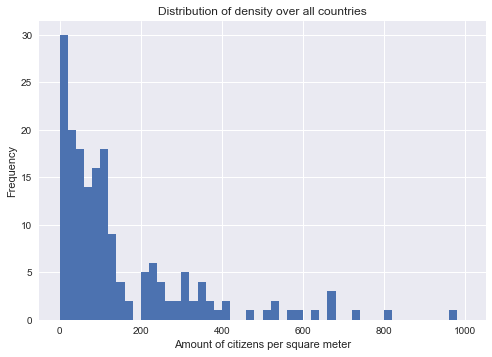

In [9]:
# Create a histogram of the density distribution
df_countryinfo['density'].hist(bins=50, range=(0, 1000))
plt.title("Distribution of density over all countries")
plt.xlabel('Amount of citizens per square meter')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

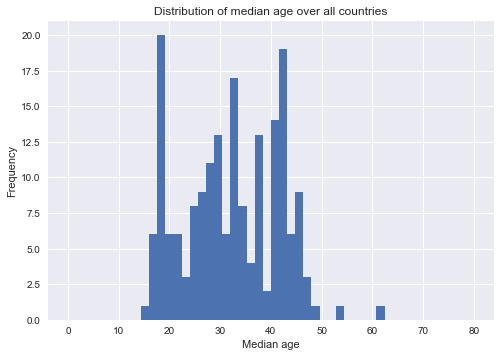

In [10]:
# Create a histogram of the median age distribution
df_countryinfo['medianage'].hist(bins=50, range=(0, 80))
plt.title("Distribution of median age over all countries")
plt.xlabel('Median age')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

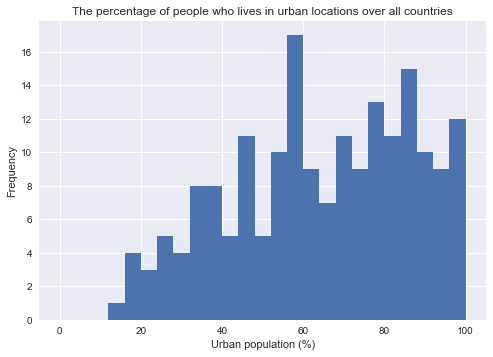

In [11]:
# Create a histogram of the percentage of people who lives in urban locations
df_countryinfo['urbanpop'].hist(bins=25, range=(0, 100))
plt.title("The percentage of people who lives in urban locations over all countries")
plt.xlabel('Urban population (%)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

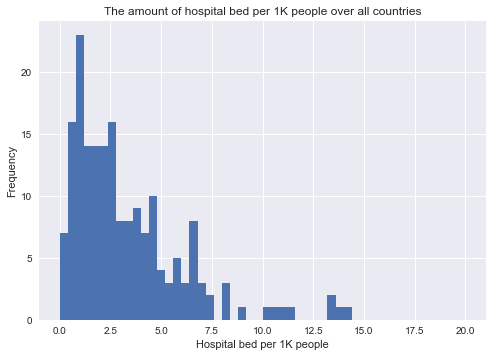

In [12]:
# Create a histogram of the amount of hospital bed per 1K people
df_countryinfo['hospibed'].hist(bins=50, range=(0, 20))
plt.title("The amount of hospital bed per 1K people over all countries")
plt.xlabel('Hospital bed per 1K people')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

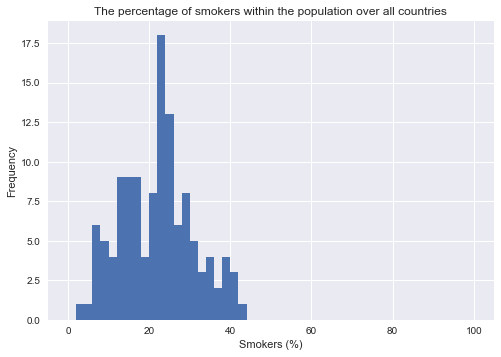

In [13]:
# Create a histogram of the % of smokers within the population.
df_countryinfo['smokers'].hist(bins=50, range=(0, 100))
plt.title("The percentage of smokers within the population over all countries")
plt.xlabel('Smokers (%)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

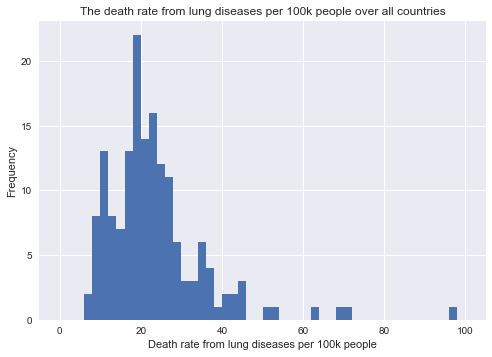

In [14]:
# Create a histogram of the death rate from lung diseases per 100k people
df_countryinfo['lung'].hist(bins=50, range=(0, 100))
plt.title("The death rate from lung diseases per 100k people over all countries")
plt.xlabel('Death rate from lung diseases per 100k people')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

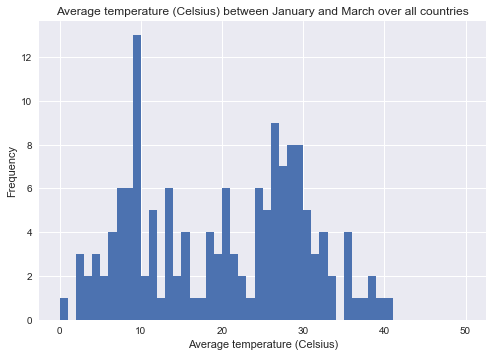

In [15]:
# Create a histogram of the average temperature (Celsius) between January and March 
df_countryinfo['avgtemp'].hist(bins=50, range=(0, 50))
plt.title("Average temperature (Celsius) between January and March over all countries")
plt.xlabel('Average temperature (Celsius)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

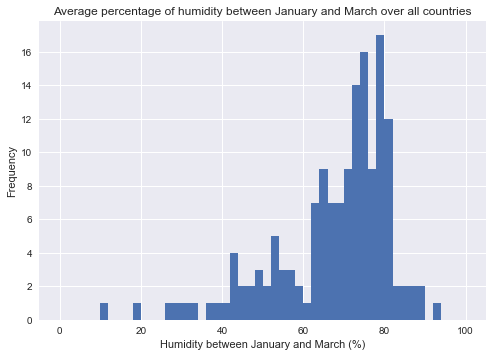

In [16]:
# Create a histogram of the average percentage of humidity between January and March
df_countryinfo['avghumidity'].hist(bins=50, range=(0, 100))
plt.title("Average percentage of humidity between January and March over all countries")
plt.xlabel('Humidity between January and March (%)')
plt.ylabel('Frequency')

It shall be checked later on whether the plotted measures have an effect on the exponentual growth rate of the outbreaks. Furthermore, the table contains other information like dates when specifc measures against the disease have been started, e.g. school closure policy. These dates might help to analyse the containment effects.

## 3. Data preparation
### Timeseries dataset
The timeseries set contains columns for each day from January 22, 2020 to show the number of cases for each country/region (as plotted above). Since the timeseries shall later on be combined with the country information dataset, it is necessary to ensure that the timeseries can be assigned to the correct country information. Thus, some preparation is required. As shown in the last chapter, some Countries/Regions are subdivided into different Provinces/States. Since the corresponding information does not exist in the country information set, the different Provinces/States are first combined by summing up the case numbers with the following function.

In [17]:
def combine_countries(df, name):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    name - string with a Country/Region for which the rows shall be combined
    
    Description:
    The function combines rows which belong to the same Country/Region by summing up the case numbers.
    For Lat and Long the mean is used. Note: This might be not the best approach in case of oversea provinces.
    '''
    
    # Copy input dataframe into output dataframe
    df_output=df.copy()
    
    # Create a new series
    new_row=pd.Series()
    
    # Assign a field for Country/Region
    new_row['Country/Region']=name
    
    # Iterate over all rows
    row_initialized=False
    counter=0
    for index, row in df_output.iterrows():
        if name==row['Country/Region']:
            
            # If the Country/Region in a row fits to name, the value of all columns are added to the new series
            for col_name, col_data in df_output.iteritems():
                if col_name!='Province/State' and col_name!='Country/Region':
                    
                    # Initially, each value of the new series is initialized
                    if not(row_initialized):
                        new_row.at[col_name]=0
                        
                    # Sum up
                    new_row.at[col_name]=new_row.at[col_name]+df_output.at[index, col_name]
                    
            row_initialized=True # Make sure to initialize only once
            counter=counter+1 # Count up every time the name==Country/Region
            
    # Take the mean of lat and long values. Note: This might be not the best approach in case of oversea provinces.
    new_row.at['Lat']=new_row.at['Lat'] / counter
    new_row.at['Long']=new_row.at['Long'] / counter
            
    # Add the new series to the output dataframe 
    df_output=df_output.append(new_row, ignore_index=True)

    return df_output # Return output dataframe

In [18]:
# Combine all Provinces/States by using the combine_countries function
df_timeseries_combined=df_timeseries.copy()
df_timeseries_combined=combine_countries(df_timeseries_combined, 'China')
df_timeseries_combined=combine_countries(df_timeseries_combined, 'Canada')
df_timeseries_combined=combine_countries(df_timeseries_combined, 'France')
df_timeseries_combined=combine_countries(df_timeseries_combined, 'United Kingdom')
df_timeseries_combined=combine_countries(df_timeseries_combined, 'Australia')
df_timeseries_combined=combine_countries(df_timeseries_combined, 'Netherlands')
df_timeseries_combined=combine_countries(df_timeseries_combined, 'Denmark')

# Replace NaNs by empty entries
df_timeseries_combined['Province/State'].fillna("", inplace=True)

# Remove rows which are no longer required (since provinces/states have been combined in new rows)
df_timeseries_combined=df_timeseries_combined[df_timeseries_combined['Province/State']=='']

# Sort according to Country/Region
df_timeseries_combined=df_timeseries_combined.sort_values(by='Country/Region')

# Drop further duplicates (countries without provinces which are already listed individually in original table)
df_timeseries_combined=df_timeseries_combined.drop([94]) # Denmark
df_timeseries_combined=df_timeseries_combined.drop([116]) # France
df_timeseries_combined=df_timeseries_combined.drop([169]) # Netherlands
df_timeseries_combined=df_timeseries_combined.drop([223]) # United Kingdom

# Reset the index (so that there are no gaps due to removed rows)
df_timeseries_combined=df_timeseries_combined.reset_index(drop=True)

In [19]:
df_timeseries_combined.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714
1,,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475
2,,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
3,,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659
4,,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19
5,,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7,7,7,7,9,15,15,15,15,19,19,19,19,21,21,23,23
6,,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265,1451,1451,1554,1628,1715,1795,1975,1975,2142,2208,2277
7,,Armenia,40.069100,45.038200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736,770,822,833,853,881,921,937,967,1013,1039,1067
8,,Australia,-31.996188,141.232788,0,0,0,0,4,5,5,6,9,9,12,12,12,13,13,14,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,25,27,30,39,52,55,60,63,76,91,107,128,128,200,250,297,377,452,568,681,791,1071,1549,1682,2044,2364,2810,3143,3640,3984,4361,4559,4862,5116,5330,5550,5687,5797,5895,6010,6108,6215,6303,6315,6351,6415
9,,Austria,47.516200,14.550100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,9,14,18,21,29,41,55,79,104,131,182,246,302,504,655,860,1018,1332,1646,2013,2388,2814,3582,4474,5283,5588,6909,7657,8271,8788,9618,10180,10711,11129,11524,11781,12051,12297,12639,12942,13244,13555,13806,13945,14041,14226


#### Create normalized timeseries dataset to overlay the rates of increase for all countries

The start dates of the outbreaks in the different countries/regions were very different. In order to compare them, the first step is to normalize everything to a "day 1" which is the day when a specific number of cases has been detected in each individual country. After that it would be possible to compare the overlaying curves.

In [20]:
def normalize_timeseries(df, outbreak_threshold):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    outbreak_threshold - int value describing at which minimal number of cases the series starts ("day 1").
                         Idea is that smaller outbreaks which are under control are not counted.
    
    OUTPUT:
    df - pandas dataframe with normalized timeseries
    
    Description:
    The input timeseries are normalized to a "day 1"
    '''

    # Create a new dataframe and copy the first 4 columns of the input set
    df_output=pd.DataFrame()
    df_output['Province/State']=df['Province/State']
    df_output['Country/Region']=df['Country/Region']
    df_output['Lat']=df['Lat']
    df_output['Long']=df['Long']
    df_output['Infections']=0 # New column which is later on used for sorting
    df_output['Outbreak_Start']='' # New column which is used to store the date of a detected outbreak (which exceeds threshold)
    
    # Iterate over all rows
    for index, row in df.iterrows():
    
        # Iterate over all columns
        counter=0
        new_column=1 # Counter for the columns in output dataframe
        for col_name, col_data in df.iteritems():
            counter=counter+1 # Count the columns
            if counter>4:     # The timeseries start from column 5
                if df.at[index, col_name]>outbreak_threshold or new_column>1: # If threshold is exceeded or if timeseries has already started
                    # Store the date of the outbreak by using the name of the original columns in which the case threshold has been exceeded
                    if new_column==1:
                        df_output.at[index, 'Outbreak_Start']=col_name       
                    df_output.at[index, str(new_column)]=df.at[index, col_name] # Copy case number in new column in output
                    new_column=new_column+1 # Count up column
                    
        # Add the number of infections
        df_output.at[index, 'Infections']=df.iloc[index, -1]
                    
    return df_output # Return output dataframe

In [21]:
df_norm=normalize_timeseries(df_timeseries_combined, 100)
df_norm.head(20)

,Province/State,Country/Region,Lat,Long,Infections,Outbreak_Start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,,Afghanistan,33.000000,65.000000,714,3/27/20,110.0,110.0,120.0,170.0,174.0,237.0,273.0,281.0,299.0,349.0,367.0,423.0,444.0,484.0,521.0,555.0,607.0,665.0,714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,Albania,41.153300,20.168300,475,3/23/20,104.0,123.0,146.0,174.0,186.0,197.0,212.0,223.0,243.0,259.0,277.0,304.0,333.0,361.0,377.0,383.0,400.0,409.0,416.0,433.0,446.0,467.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,Algeria,28.033900,1.659600,2070,3/21/20,139.0,201.0,230.0,264.0,302.0,367.0,409.0,454.0,511.0,584.0,716.0,847.0,986.0,1171.0,1251.0,1320.0,1423.0,1468.0,1572.0,1666.0,1761.0,1825.0,1914.0,1983.0,2070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,Andorra,42.506300,1.521800,659,3/22/20,113.0,133.0,164.0,188.0,224.0,267.0,308.0,334.0,370.0,376.0,390.0,428.0,439.0,466.0,501.0,525.0,545.0,564.0,583.0,601.0,601.0,638.0,646.0,659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,Angola,-11.202700,17.873900,19,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,,Antigua and Barbuda,17.060800,-61.796400,23,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,,Argentina,-38.416100,-63.616700,2277,3/20/20,128.0,158.0,266.0,301.0,387.0,387.0,502.0,589.0,690.0,745.0,820.0,1054.0,1054.0,1133.0,1265.0,1451.0,1451.0,1554.0,1628.0,1715.0,1795.0,1975.0,1975.0,2142.0,2208.0,2277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,,Armenia,40.069100,45.038200,1067,3/19/20,115.0,136.0,160.0,194.0,235.0,249.0,265.0,290.0,329.0,407.0,424.0,482.0,532.0,571.0,663.0,736.0,770.0,822.0,833.0,853.0,881.0,921.0,937.0,967.0,1013.0,1039.0,1067.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,,Australia,-31.996188,141.232788,6415,3/10/20,107.0,128.0,128.0,200.0,250.0,297.0,377.0,452.0,568.0,681.0,791.0,1071.0,1549.0,1682.0,2044.0,2364.0,2810.0,3143.0,3640.0,3984.0,4361.0,4559.0,4862.0,5116.0,5330.0,5550.0,5687.0,5797.0,5895.0,6010.0,6108.0,6215.0,6303.0,6315.0,6351.0,6415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Now all timeseries start on the same day (column "1"). In the following, the countries with the highest number of cases at the end of the timeseries are visualized by the previously defined function. Before doing this, another function is required to sort according to the number of infections which is no longer possible out-of-the-box (last column of timeseries cannot be used).

In [22]:
def sort_according_to_number_of_infections(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries of number of infections
    
    OUTPUT:
    df - pandas dataframe in which the rows are sorted according to the number of infections
    
    Description:
    Sorts the rows in a descending manner according the number of infections
    '''

    # Create output dataframe
    df_output=df.copy()
    
    # If the columns with the number of infections is already there (create by normalize_timeseries), sort according to it.
    if 'Infections' in df:
        # Sort according to number of infections
        df_output=df_output.sort_values(by='Infections', ascending=False)
        
    # If the column does not exist, create it temporarily and sort accoring to it.
    else:
        # Iterate over all rows
        for index, row in df_output.iterrows():
    
            # Iterate over all columns
            counter=0 # 
            infections=0
            for col_name, col_data in df_output.iteritems():
                counter=counter+1 # Count the columns
                if counter>4:     # The timeseries start from column 5
                    if df_output.at[index, col_name]>infections:
                        infections=df_output.at[index, col_name] # If there is a higher number of cases, overwrite old value
                
            df_output.at[index, 'Infections']=infections
    
        # Sort according to number of infections
        df_output=df_output.sort_values(by='Infections', ascending=False)
    
        # Delete helper column after sorting
        del df_output['Infections']
        
    return df_output

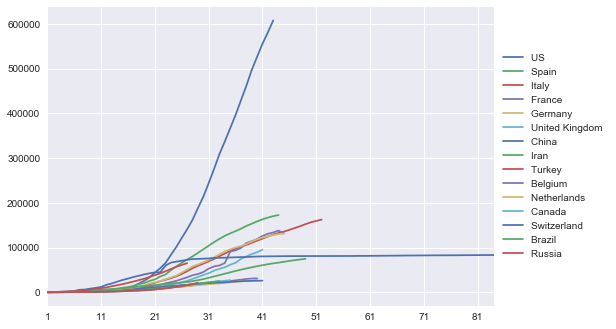

In [23]:
# Visualize the 15 countries with the highest number of infections (sorted ascendingly and select top 15)
visualize_timeseries(sort_according_to_number_of_infections(df_norm).head(15), False)

In order to compare the different curves, the idea is to find a measure describing the exponential growth which obviously starts directly after a detected outbreak. However, each curve shows after some specific timepoint a trend to a more linear growth. This might be the result of governmental measures, attitude changes of the population, and possible saturation effects of local outbreaks. A visualization with a logarithmic scale of the y-axis shows this much better.

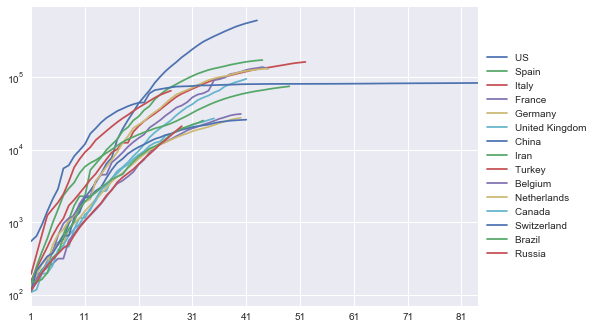

In [24]:
# Visualize the 15 countries with the highest number of infections (sorted ascendingly and select top 15) on a log-scale
visualize_timeseries(sort_according_to_number_of_infections(df_norm).head(15), True)

An important point to understand the differences in exponential growth of the curves is to find out at which timepoint this type of growth ends. An idea for this would be to take the timepoint at which the steepest increase takes place. After this point, the outbreak obviously looses speed. Mathematically, this point is the second derivative of the function describing the cumulative number of cases. Before calculating this, the data will be applied to a noise filter. The function for this filter is defined in the next step. Here a Savitzky-Golay filter is used which bases on a polynomial regression. It is less biased than a sliding window filter using the mean.

In [25]:
def savitzky_golay_filter(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which which is the filtered input dataframe
    
    Description:
    A Savitzky-Golay filter is used for the filtering
    '''

    # Create output dataframe
    df_output=df.copy()
    
    # Iterate over all rows
    for index, row in df_output.iterrows():
        
        # Create a list which is used to call the savgol_filter function
        value_list=[]
        
        # Iterate over all columns
        counter=0 # 
        for col_name, col_data in df_output.iteritems():
            counter=counter+1 # Count the columns
            if counter>4:     # The timeseries start from column 5
                if col_name!='Infections' and col_name!='Outbreak_Start' and not(np.isnan(df_output.at[index, col_name])):
                    value_list.append(df_output.at[index, col_name]) # Add value to list
        
        # Call the savgol_filter function
        if len(value_list) >= 5:
            value_list=savgol_filter(value_list, 5, 2)

        # Create an iterator to itereate through the savgol_filter output
        value_liste_iterator=iter(value_list)
        
        # Iterate over all columns
        counter=0 # 
        for col_name, col_data in df_output.iteritems():
            counter=counter+1 # Count the columns
            if counter>4:     # The timeseries start from column 5
                if col_name!='Infections' and col_name!='Outbreak_Start' and not(np.isnan(df_output.at[index, col_name])):
                    df_output.at[index, col_name]=next(value_liste_iterator) # Write output in output dataframe
                
    return df_output
    

In [26]:
# Create a dataframe as a filtered version of the normalized dataframe
df_filtered=savitzky_golay_filter(df_norm)
#df_filtered=df_norm

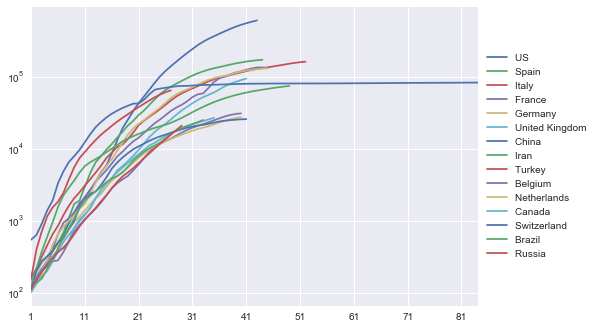

In [27]:
# Visualize in filtered data the 15 countries with the highest number of infections (sorted ascendingly and select top 15) on a log-scale
visualize_timeseries(sort_according_to_number_of_infections(df_filtered).head(15), True)

The next step is to calculate the derivatives. A derivative of a function describes the slope of the function. Applied to the cumulative growth of the Corona cases, the first derivative is simply the number of new detected cases per day. This is done in the following function. If the function is applied twice, the second derivative is calculated.

In [28]:
def derivative(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which represents a derivative of the input dataframe
    
    Description:
    In the derivative for a timeseries, datapoint x is the differences of point x and x-1 from the input array.
    '''

    # Create output dataframe
    df_output=df.copy()
    
    # Iterate over all rows
    for index, row in df.iterrows():
    
        # Iterate over all columns
        counter=0 # 
        increase=0
        last_col_name=0
        for col_name, col_data in df.iteritems():
            counter=counter+1 # Count the columns
            if counter>4 and col_name!='Infections' and col_name!='Outbreak_Start':
                if last_col_name != 0:
                    # Caluculate the difference of the current column and the last one (at current row)
                    df_output.at[index, col_name]=df.at[index, col_name]-df.at[index, last_col_name]
                    last_col_name=col_name
                else:
                    df_output.at[index, col_name]=0
                    last_col_name=col_name        
    return df_output


In [29]:
df_derivative=derivative(df_filtered)

In [30]:
df_derivative.head()

,Province/State,Country/Region,Lat,Long,Infections,Outbreak_Start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,,Afghanistan,33.0000,65.0000,714,3/27/20,0.0,8.514286,15.371429,23.685714,36.742857,39.342857,39.942857,12.714286,24.000000,31.142857,41.742857,32.857143,38.400000,31.600000,37.085714,38.628571,49.428571,52.171429,57.314286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,Albania,41.1533,20.1683,475,3/23/20,0.0,23.428571,22.142857,23.028571,15.942857,11.257143,12.085714,15.028571,16.142857,17.542857,19.285714,25.457143,30.028571,26.200000,15.485714,11.057143,11.428571,10.628571,9.742857,12.542857,18.057143,14.485714,13.057143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,Algeria,28.0339,1.6596,2070,3/21/20,0.0,48.114286,41.971429,28.600000,46.314286,52.228571,49.971429,43.971429,53.228571,85.171429,117.257143,134.428571,157.685714,147.800000,105.200000,76.542857,73.342857,78.857143,81.200000,104.542857,83.771429,80.200000,73.228571,79.457143,83.171429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,Andorra,42.5063,1.5218,659,3/22/20,0.0,22.342857,25.914286,29.228571,34.285714,43.000000,37.400000,34.828571,23.742857,14.571429,17.857143,24.200000,23.428571,23.571429,31.828571,26.571429,19.828571,19.000000,20.200000,10.457143,16.542857,18.057143,15.885714,15.457143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,Angola,-11.2027,17.8739,19,,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


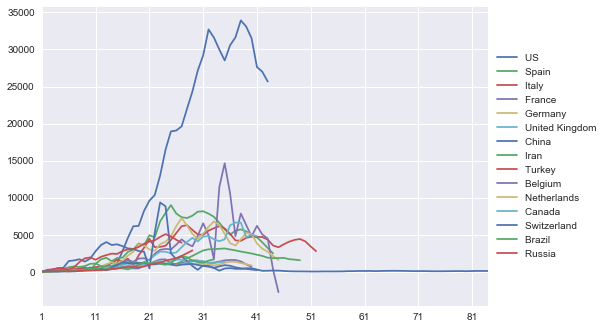

In [31]:
# Visualize the 1st derivative of 15 countries with the highest number of infections
visualize_timeseries(sort_according_to_number_of_infections(df_derivative).head(15), False)

Some of the derivatives seem to show cyclic fluctuations on a weekly base. A reason might be that new cases on weekend are reported with delay to the health authorities. Thus, a median filter with a width of 7 (for 7 days per week) is applied to the derivatives before the next step. The filter is implemented in the following function:

In [32]:
def median_filter(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which which is the filtered input dataframe
    
    Description:
    A Savitzky-Golay filter is used for the filtering
    '''

    # Create output dataframe
    df_output=df.copy()
    
    # Iterate over all rows
    for index, row in df_output.iterrows():
        
        # Create a list which is used to call the savgol_filter function
        value_list=[]
        
        # Iterate over all columns
        counter=0 # 
        for col_name, col_data in df_output.iteritems():
            counter=counter+1 # Count the columns
            if counter>4:     # The timeseries start from column 5
                if col_name!='Infections' and col_name!='Outbreak_Start' and not(np.isnan(df_output.at[index, col_name])):
                    value_list.append(df_output.at[index, col_name]) # Add value to list
        
        # Call the savgol_filter function
        if len(value_list) >= 5:
            value_list=medfilt(value_list, 7)

        # Create an iterator to itereate through the savgol_filter output
        value_liste_iterator=iter(value_list)
        
        # Iterate over all columns
        counter=0 # 
        for col_name, col_data in df_output.iteritems():
            counter=counter+1 # Count the columns
            if counter>4:     # The timeseries start from column 5
                if col_name!='Infections' and col_name!='Outbreak_Start' and not(np.isnan(df_output.at[index, col_name])):
                    df_output.at[index, col_name]=next(value_liste_iterator) # Write output in output dataframe
                
    return df_output

In [33]:
# Apply median filter to compensate that new cases on weekend are reported with delay to the health authorities
df_derivative_filtered=median_filter(df_derivative)

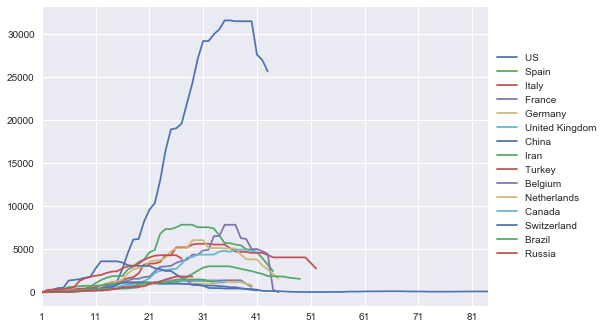

In [34]:
# Visualize the 1st derivative of 15 countries with the highest number of infections
visualize_timeseries(sort_according_to_number_of_infections(df_derivative_filtered).head(15), False)

In [35]:
# Calculate the 2nd derivative
df_2nd_derivative_filtered=derivative(df_derivative_filtered)

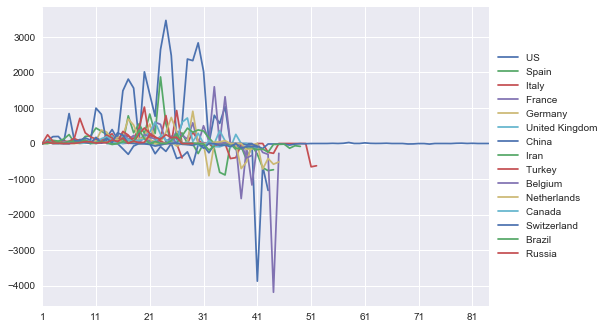

In [36]:
# Visualize the 2nd derivative of 15 countries with the highest number of infections
visualize_timeseries(sort_according_to_number_of_infections(df_2nd_derivative_filtered).head(15), False)

In the next step a function is implemented which calculates the maximum of each row value. Applied to the second derivative, it is the already mentioned point of steepest increase of case numbers.

In [37]:
def add_max_value_and_index(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - input dataframe extended by max value and max index columns
    
    Description:
    Adds two columns
    '''

    df_output=df.copy()
    df_output['Max_Value'] = 0
    df_output['Max_Index'] = 0
    
    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
        
        value_list=[]
        
        # Iterate over all columns
        counter=0
        for col_name, col_data in df.iteritems():
            counter=counter+1 # Count the columns
            if counter>4 and col_name!='Infections' and col_name!='Outbreak_Start' and not(np.isnan(df_output.at[index, col_name])):
                value_list.append(df_output.at[index, col_name])

        max_value = max(value_list)
        max_index = value_list.index(max_value)
        
        df_output.at[index, 'Max_Value'] = max_value
        df_output.at[index, 'Max_Index'] = max_index

    return df_output

In [38]:
# Apply the function to get the max value and the corresponding index and add both to the dataframe
df_2nd_derivative_filtered=add_max_value_and_index(df_2nd_derivative_filtered)

In [39]:
df_2nd_derivative_filtered.head(20)

,Province/State,Country/Region,Lat,Long,Infections,Outbreak_Start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Max_Value,Max_Index
0,,Afghanistan,33.000000,65.000000,714,3/27/20,0.0,8.514286,6.857143,8.314286,0.000000,0.314286,7.142857,5.600000,-3.885714,0.000000,-1.257143,1.257143,4.228571,1.314286,0.000000,0.228571,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1
1,,Albania,41.153300,20.168300,475,3/23/20,0.0,15.942857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,1.400000,1.742857,0.000000,0.000000,0.000000,-3.800000,-4.057143,0.000000,0.000000,0.000000,1.114286,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,1
2,,Algeria,28.033900,1.659600,2070,3/21/20,0.0,28.600000,13.371429,4.342857,0.000000,0.000000,3.657143,2.257143,1.000000,31.942857,32.085714,0.000000,0.000000,0.000000,-12.057143,-24.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,-1.000000,-0.742857,-6.228571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,10
3,,Andorra,42.506300,1.521800,659,3/22/20,0.0,22.342857,3.571429,3.314286,5.057143,0.000000,0.000000,0.000000,-10.085714,-0.457143,-0.171429,0.000000,0.000000,0.000000,0.000000,-0.142857,-3.228571,-0.371429,-0.828571,-0.942857,-1.514286,-0.657143,-0.428571,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,1
4,,Angola,-11.202700,17.873900,19,,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5,,Antigua and Barbuda,17.060800,-61.796400,23,,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6,,Argentina,-38.416100,-63.616700,2277,3/20/20,0.0,34.657143,23.085714,0.714286,4.857143,6.342857,0.000000,0.000000,11.800000,8.114286,0.000000,0.000000,30.428571,0.000000,-30.428571,0.000000,-8.142857,12.800000,-1.142857,0.000000,0.000000,0.000000,-1.457143,0.000000,-5.285714,-3.942857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,1
7,,Armenia,40.069100,45.038200,1067,3/19/20,0.0,19.085714,2.200000,0.000000,1.828571,3.114286,6.714286,0.000000,8.171429,6.142857,0.942857,1.771429,0.000000,0.571429,0.000000,0.000000,0.000000,-17.828571,-0.857143,-1.628571,-0.057143,0.000000,0.057143,0.000000,-0.057143,-2.114286,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

After finding out the value of the steepest slope in the growth curve, it shall also be checked whether there is a measure to compare effects of mitigations against the disease. This is of course not easy since the disease is still spreading. However, here the following criterion shall be checked: At some point after the maximal growth, the increase becomes slower and the number of additional cases per days decreases. At some point, the maximal number of additional cases per day is reached. This is exactly covered by the maximum of the first derivative. The question is now, how fast this point is reached. Obviously, the faster this goes, the better might be the measures. However, also other effects might play a role here.

In [40]:
# Apply the function to get the max value and the corresponding index and add both to the dataframe
df_derivative=add_max_value_and_index(df_derivative)

In [41]:
df_derivative.head(20)

,Province/State,Country/Region,Lat,Long,Infections,Outbreak_Start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Max_Value,Max_Index
0,,Afghanistan,33.000000,65.000000,714,3/27/20,0.0,8.514286,15.371429,23.685714,36.742857,39.342857,39.942857,12.714286,24.000000,31.142857,41.742857,32.857143,38.400000,31.600000,37.085714,38.628571,49.428571,52.171429,57.314286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,18
1,,Albania,41.153300,20.168300,475,3/23/20,0.0,23.428571,22.142857,23.028571,15.942857,11.257143,12.085714,15.028571,16.142857,17.542857,19.285714,25.457143,30.028571,26.200000,15.485714,11.057143,11.428571,10.628571,9.742857,12.542857,18.057143,14.485714,13.057143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,12
2,,Algeria,28.033900,1.659600,2070,3/21/20,0.0,48.114286,41.971429,28.600000,46.314286,52.228571,49.971429,43.971429,53.228571,85.171429,117.257143,134.428571,157.685714,147.800000,105.200000,76.542857,73.342857,78.857143,81.200000,104.542857,83.771429,80.200000,73.228571,79.457143,83.171429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157,12
3,,Andorra,42.506300,1.521800,659,3/22/20,0.0,22.342857,25.914286,29.228571,34.285714,43.000000,37.400000,34.828571,23.742857,14.571429,17.857143,24.200000,23.428571,23.571429,31.828571,26.571429,19.828571,19.000000,20.200000,10.457143,16.542857,18.057143,15.885714,15.457143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,5
4,,Angola,-11.202700,17.873900,19,,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5,,Antigua and Barbuda,17.060800,-61.796400,23,,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6,,Argentina,-38.416100,-63.616700,2277,3/20/20,0.0,57.742857,63.314286,80.942857,34.657143,58.457143,69.657143,111.600000,81.457143,59.542857,126.857143,127.885714,89.571429,47.628571,154.971429,120.000000,81.428571,52.000000,94.228571,70.800000,124.057143,93.085714,106.457143,82.400000,86.342857,91.628571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154,14
7,,Armenia,40.069100,45.038200,1067,3/19/20,0.0,19.085714,26.228571,35.800000,32.942857,21.285714,14.285714,23.114286,51.428571,49.971429,47.257143,41.114286,48.200000,56.400000,75.885714,70.857143,50.542857,32.714286,24.714286,15.200000,31.857143,30.228571,25.428571,30.171429,37.771429,31.

With the maximum values previouslöy calculated, it is now possible to derive measures to compüare grwoth and effect of measures between different countries. For this, the following two functions are used.

In [42]:
def calc_growth_factor(df_norm, df_2nd_derivative):
    '''
    INPUT:
    df_norm - pandas dataframe with timeseries
    df_2nd_derivative - pandas dataframe with the 2nd derivative of the timeseries
    
    Description:
    Adds a column with the cummulative case value at which the 2nd derivative has its maximum ('Max_Value').
    Additionally, the corresponding index is stored ('Max_Index').
    Calculates the growth factor till reaching the max value. Result is stored in 'Growth_Factor'.
    '''

    df_norm['Max_Index']=0

    # Iterate over all rows
    for index, row in df_norm.iterrows():
        
        # Iterate over all columns
        counter=0
        index_counter=0
        for col_name, col_data in df_norm.iteritems():
            counter=counter+1 # Count the columns
            if counter>4 and col_name!='Infections' and col_name!='Outbreak_Start' and not(np.isnan(df_norm.at[index, col_name])):
                if index_counter==df_2nd_derivative.at[index, 'Max_Index']:
                    df_norm.at[index, 'Max_Index']=df_2nd_derivative.at[index, 'Max_Index']
                    df_norm.at[index, 'Max_Value']=df_norm.at[index, col_name]
                index_counter=index_counter+1

    # Caluculate the growth factor
    df_norm['Growth_Factor']=(df_norm['Max_Value']/100)**(1.0/df_2nd_derivative['Max_Index'])
    
    
def calc_measure_effect(df_norm, df_derivative):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    df_derivative - pandas dataframe with the derivative of the timeseries
    
    Description:
    Calculates the number of days between reaching the steepest increase in growth till the maximal number of cases per day
    The shorter the number, the better are obviously the measures in this model.
    '''

    df_norm['Days_till_Max']=0

    # Iterate over all rows
    for index, row in df_norm.iterrows():
        df_norm.at[index, 'Days_till_Max']=df_derivative.at[index, 'Max_Index'] - df_norm.at[index, 'Max_Index']


In [43]:
# Calculate the growth factor (added to df_norm)
calc_growth_factor(df_norm, df_2nd_derivative_filtered)

In [44]:
# Calculate the effect of measures (added to df_norm)
calc_measure_effect(df_norm, df_derivative)

In [45]:
df_norm.head(20)

,Province/State,Country/Region,Lat,Long,Infections,Outbreak_Start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Max_Index,Max_Value,Growth_Factor,Days_till_Max
0,,Afghanistan,33.000000,65.000000,714,3/27/20,110.0,110.0,120.0,170.0,174.0,237.0,273.0,281.0,299.0,349.0,367.0,423.0,444.0,484.0,521.0,555.0,607.0,665.0,714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,110.0,1.100000,17
1,,Albania,41.153300,20.168300,475,3/23/20,104.0,123.0,146.0,174.0,186.0,197.0,212.0,223.0,243.0,259.0,277.0,304.0,333.0,361.0,377.0,383.0,400.0,409.0,416.0,433.0,446.0,467.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,123.0,1.230000,11
2,,Algeria,28.033900,1.659600,2070,3/21/20,139.0,201.0,230.0,264.0,302.0,367.0,409.0,454.0,511.0,584.0,716.0,847.0,986.0,1171.0,1251.0,1320.0,1423.0,1468.0,1572.0,1666.0,1761.0,1825.0,1914.0,1983.0,2070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,716.0,1.217563,2
3,,Andorra,42.506300,1.521800,659,3/22/20,113.0,133.0,164.0,188.0,224.0,267.0,308.0,334.0,370.0,376.0,390.0,428.0,439.0,466.0,501.0,525.0,545.0,564.0,583.0,601.0,601.0,638.0,646.0,659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,133.0,1.330000,4
4,,Angola,-11.202700,17.873900,19,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.000000,0
5,,Antigua and Barbuda,17.060800,-61.796400,23,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.000000,0
6,,Argentina,-38.416100,-63.616700,2277,3/20/20,128.0,158.0,266.0,301.0,387.0,387.0,502.0,589.0,690.0,745.0,820.0,1054.0,1054.0,1133.0,1265.0,1451.0,1451.0,1554.0,1628.0,1715.0,1795.0,1975.0,1975.0,2142.0,2208.0,2277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,158.0,1.580000,13
7,,Armenia,40.069100,45.038200,1067,3/19/20,115.0,136.0,160.0,194.0,235.0,249.0,265.0,290.0,329.0,407.0,424.0,482.0,532.0,571.0,663.0,736.0,770.0,822.0,833.0,853.0,881.0,921.0,937.0,967.0,1013.0,1039.0,1067.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,136.0,1.360000,13
8,,Australia,-31.996188,141.232788,6415,3/10/20,107.0,128.0,128.0,200.0,250.0,297.0,377.0,452.0,568.0,681.0,791.0,1071.0,1549.0,1682.0

### Country information dataset
Now, the countryinfo dataset is prepared. Also here it is required to remove rows to make it compatible with the timeseries dataset. In the first step, all US states are removed, since for these ones not data exist in the series, since in contains only a combined row for the US (from the beginning, not just after preprocessing).

In [46]:
df_countryinfo_reduced=df_countryinfo.copy()

# Replace NaNs by empty entries
df_countryinfo_reduced['region'].fillna("", inplace=True)

# Remove rows which are no longer required (since provinces/states have been combined in new rows)
df_countryinfo_reduced=df_countryinfo_reduced[df_countryinfo_reduced['region']=='']

# Sort according to country
df_countryinfo_reduced=df_countryinfo_reduced.sort_values(by='country')

# Reset the index (so that there are no gaps due to removed rows)
df_countryinfo_reduced=df_countryinfo_reduced.reset_index(drop=True)

df_countryinfo_reduced.head(20)

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,publicplace,gatheringlimit,gathering,nonessential,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity,firstcase,totalcases,active30,active31,active1,active2,active3,newcases30,newcases31,newcases1,newcases2,newcases3,deaths,newdeaths30,newdeaths31,newdeaths1,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m
0,,Afghanistan,AFG,AF,"38,928,346",NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333,2/23/2020,273,139,165,187,225,257,25,4,22,2,NaN,6,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,7,0.20
1,,Albania,ALB,AL,"2,877,797",NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9,29.40,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04,"15,418",774,268.955733,1.51,13.950000,69.900000,3/7/2020,304,168,176,177,194,199,11,20,16,18,27,16,1.0,4.0,NaN,1.0,NaN,89,7,8,7,7,7,106,6.00
2,,Algeria,DZA,DZ,"43,851,044",NaN,NaN,18.0,29.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,1.9,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81,"172,781","1,031",23.511413,2.70,19.566667,61.716667,2/24/2020,986,449,626,728,728,839,NaN,132,131,NaN,NaN,86,NaN,9.0,14.0,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,22,2.00
3,,Andorra,AND,AD,"77,265",NaN,NaN,164.0,45.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5,32.50,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN,"91,527","5,949",76994.758300,1.40,7.383333,75.233333,3/1/2020,439,322,352,366,403,407,NaN,NaN,14,38,11,16,NaN,NaN,2.0,1.0,1.0,16,10,10,12,12,12,"5,682",207.00
4,,Antigua and Barbuda,ATG,AG,"97,929",NaN,NaN,223.0,34.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78,"1,688","1,105",11283.685120,2.00,NaN,NaN,3/12/2020,9,7,7,7,7,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,NaN
5,,Argentina,ARG,AR,"45,195,774",NaN,NaN,17.0,32.0,93.0,3/20/2020,NaN,NaN,NaN,NaN,NaN,5.0,23.95,1.05,1.06,1.05,1.00,0.94,0.71,0.98,29.27,20.16,42.59,"445,469","1,390",30.755088,2.26,32.816667,43.616667,3/2/2020,"1,265",570,700,778,851,970,NaN,146,NaN,NaN,NaN,39,2.0,3.0,1.0,2.0,3.0,256,NaN,NaN,NaN,NaN,NaN,28,0.90
6,,Armenia,ARM,AM,"2,963,243",694.0,4269.802594,104.0,35.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,4.2,26.90,1.13,1.14,1.06,0.93,0.84,0.67,0.94,23.86,16.17,35.99,"13,444",883,297.984337,1.64,7.100000,58.500000,2/29/2020,736,449,499,536,625,686,58,50,39,92,73,7,NaN,NaN,1.0,1.0,NaN,43,15,30,30,30,30,248,2.00
7,,Australia,AUS,AU,"25,499,884",31635.0,806.065560,3.0,38.0,86.0,NaN,NaN,3/23/2020,2.0,3/29/2020,NaN,3.8,14.90,1.06,1.06,1.09,0.99,0.93,0.86,0.99,18.79,15.90,22.16,"1,376,255","4,492",176.157664,1.77,25.783333,64.233333,1/24/2020,"5,350","3,983","4,205","4,498","4,767","4,737",82,101,101,89,36,28,1.0,NaN,1.0,2.0,3.0,585,28,28,50,50,85,210,1.00
8,,Austria,AUT,AT,"9,006,398",10278.0,876.279237,109.0,43.0,57.0,3/16/2020,NaN,NaN,NaN,NaN,NaN,7.6,35.15,1.05,1.05,1.04,1.00,0.98,0.76,0.96,17.02,13.02,22.14,"447,718","5,138",570.483339,1.47,9.466667,65.350000,2/24/2020,"11,444","8,710","8,886","9,003","9,120","9,254",666,491,405,316,315,168,22.0,20.0,18.0,12.0,10.0,"2,022",193,198,215,227,245,"1,271",19.00
9,,Azerbaijan,AZE,AZ,"10,139,177",NaN,NaN,123.0,32.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,4.7,23.45,1.11,1.15,1.09,0.96,0.86,0.62,0.98,20.61,14.07,29.32,"47,171","1,191",117.465155,1.89,10.166667,68.083333,2/27/2020,443,243,267,328,369,406,64,25,61,41,43,5,NaN,1.0,NaN,NaN,NaN,32,23,11,7,7,7,44,0.50


In the next step, the columns that are not automatically interpreted as numbers are converted.

In [47]:
# Replace the comma-delimiter which lead to a wrong interpretation of the columns 
df_countryinfo_reduced['pop'] = df_countryinfo_reduced['pop'].str.replace(',', '')
df_countryinfo_reduced['gdp2019'] = df_countryinfo_reduced['gdp2019'].str.replace(',', '')

In [48]:
# Convert cells into numbers
df_countryinfo_reduced['pop'] = df_countryinfo_reduced['pop'].astype('float64')
df_countryinfo_reduced['gdp2019'] = df_countryinfo_reduced['gdp2019'].astype('float64')

In [49]:
df_countryinfo_reduced.head(20)

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,publicplace,gatheringlimit,gathering,nonessential,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity,firstcase,totalcases,active30,active31,active1,active2,active3,newcases30,newcases31,newcases1,newcases2,newcases3,deaths,newdeaths30,newdeaths31,newdeaths1,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m
0,,Afghanistan,AFG,AF,38928346.0,NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,18734.0,184,4.726633,5.12,6.216667,56.933333,2/23/2020,273,139,165,187,225,257,25,4,22,2,NaN,6,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,7,0.20
1,,Albania,ALB,AL,2877797.0,NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9,29.40,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04,15418.0,774,268.955733,1.51,13.950000,69.900000,3/7/2020,304,168,176,177,194,199,11,20,16,18,27,16,1.0,4.0,NaN,1.0,NaN,89,7,8,7,7,7,106,6.00
2,,Algeria,DZA,DZ,43851044.0,NaN,NaN,18.0,29.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,1.9,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81,172781.0,"1,031",23.511413,2.70,19.566667,61.716667,2/24/2020,986,449,626,728,728,839,NaN,132,131,NaN,NaN,86,NaN,9.0,14.0,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,22,2.00
3,,Andorra,AND,AD,77265.0,NaN,NaN,164.0,45.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5,32.50,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN,91527.0,"5,949",76994.758300,1.40,7.383333,75.233333,3/1/2020,439,322,352,366,403,407,NaN,NaN,14,38,11,16,NaN,NaN,2.0,1.0,1.0,16,10,10,12,12,12,"5,682",207.00
4,,Antigua and Barbuda,ATG,AG,97929.0,NaN,NaN,223.0,34.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78,1688.0,"1,105",11283.685120,2.00,NaN,NaN,3/12/2020,9,7,7,7,7,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,NaN
5,,Argentina,ARG,AR,45195774.0,NaN,NaN,17.0,32.0,93.0,3/20/2020,NaN,NaN,NaN,NaN,NaN,5.0,23.95,1.05,1.06,1.05,1.00,0.94,0.71,0.98,29.27,20.16,42.59,445469.0,"1,390",30.755088,2.26,32.816667,43.616667,3/2/2020,"1,265",570,700,778,851,970,NaN,146,NaN,NaN,NaN,39,2.0,3.0,1.0,2.0,3.0,256,NaN,NaN,NaN,NaN,NaN,28,0.90
6,,Armenia,ARM,AM,2963243.0,694.0,4269.802594,104.0,35.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,4.2,26.90,1.13,1.14,1.06,0.93,0.84,0.67,0.94,23.86,16.17,35.99,13444.0,883,297.984337,1.64,7.100000,58.500000,2/29/2020,736,449,499,536,625,686,58,50,39,92,73,7,NaN,NaN,1.0,1.0,NaN,43,15,30,30,30,30,248,2.00
7,,Australia,AUS,AU,25499884.0,31635.0,806.065560,3.0,38.0,86.0,NaN,NaN,3/23/2020,2.0,3/29/2020,NaN,3.8,14.90,1.06,1.06,1.09,0.99,0.93,0.86,0.99,18.79,15.90,22.16,1376255.0,"4,492",176.157664,1.77,25.783333,64.233333,1/24/2020,"5,350","3,983","4,205","4,498","4,767","4,737",82,101,101,89,36,28,1.0,NaN,1.0,2.0,3.0,585,28,28,50,50,85,210,1.00
8,,Austria,AUT,AT,9006398.0,10278.0,876.279237,109.0,43.0,57.0,3/16/2020,NaN,NaN,NaN,NaN,NaN,7.6,35.15,1.05,1.05,1.04,1.00,0.98,0.76,0.96,17.02,13.02,22.14,447718.0,"5,138",570.483339,1.47,9.466667,65.350000,2/24/2020,"11,444","8,710","8,886","9,003","9,120","9,254",666,491,405,316,315,168,22.0,20.0,18.0,12.0,10.0,"2,022",193,198,215,227,245,"1,271",19.00
9,,Azerbaijan,AZE,AZ,10139177.0,NaN,NaN,123.0,32.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,4.7,23.45,1.11,1.15,1.09,0.96,0.86,0.62,0.98,20.61,14.07,29.32,47171.0,"1,191",117.465155,1.89,10.166667,68.083333,2/27/2020,443,243,267,328,369,406,64,25,61,41,43,5,NaN,1.0,NaN,NaN,NaN,32,23,11,7,7,7,44,0.50


### Merge datasets

In [130]:
# Change column name before merging (merged dataframes neend an identical column)
df_norm.rename(columns={'Country/Region': 'country'}, inplace=True)
df_norm.head()

,Province/State,country,Lat,Long,Infections,Outbreak_Start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Max_Index,Max_Value,Growth_Factor,Days_till_Max
0,,Afghanistan,33.0000,65.0000,714,3/27/20,110.0,110.0,120.0,170.0,174.0,237.0,273.0,281.0,299.0,349.0,367.0,423.0,444.0,484.0,521.0,555.0,607.0,665.0,714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,110.0,1.100000,17
1,,Albania,41.1533,20.1683,475,3/23/20,104.0,123.0,146.0,174.0,186.0,197.0,212.0,223.0,243.0,259.0,277.0,304.0,333.0,361.0,377.0,383.0,400.0,409.0,416.0,433.0,446.0,467.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,123.0,1.230000,11
2,,Algeria,28.0339,1.6596,2070,3/21/20,139.0,201.0,230.0,264.0,302.0,367.0,409.0,454.0,511.0,584.0,716.0,847.0,986.0,1171.0,1251.0,1320.0,1423.0,1468.0,1572.0,1666.0,1761.0,1825.0,1914.0,1983.0,2070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,716.0,1.217563,2
3,,Andorra,42.5063,1.5218,659,3/22/20,113.0,133.0,164.0,188.0,224.0,267.0,308.0,334.0,370.0,376.0,390.0,428.0,439.0,466.0,501.0,525.0,545.0,564.0,583.0,601.0,601.0,638.0,646.0,659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,133.0,1.330000,4
4,,Angola,-11.2027,17.8739,19,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.000000,0


In [131]:
df_all = pd.merge(df_countryinfo_reduced, df_norm , on='country', how='inner')

In [132]:
df_all.head(20)

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,publicplace,gatheringlimit,gathering,nonessential,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity,firstcase,totalcases,active30,active31,active1,active2,active3,newcases30,newcases31,newcases1,newcases2,newcases3,deaths,newdeaths30,newdeaths31,newdeaths1,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m,Province/State,Lat,Long,Infections,Outbreak_Start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Max_Index,Max_Value,Growth_Factor,Days_till_Max
0,,Afghanistan,AFG,AF,38928346.0,NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,18734.0,184,4.726633,5.12,6.216667,56.933333,2/23/2020,273,139,165,187,225,257,25,4,22,2,NaN,6,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,7,0.20,,33.000000,65.000000,714,3/27/20,110.0,110.0,120.0,170.0,174.0,237.0,273.0,281.0,299.0,349.0,367.0,423.0,444.0,484.0,521.0,555.0,607.0,665.0,714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,110.0,1.100000,17
1,,Albania,ALB,AL,2877797.0,NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9,29.40,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04,15418.0,774,268.955733,1.51,13.950000,69.900000,3/7/2020,304,168,176,177,194,199,11,20,16,18,27,16,1.0,4.0,NaN,1.0,NaN,89,7,8,7,7,7,106,6.00,,41.153300,20.168300,475,3/23/20,104.0,123.0,146.0,174.0,186.0,197.0,212.0,223.0,243.0,259.0,277.0,304.0,333.0,361.0,377.0,383.0,400.0,409.0,416.0,433.0,446.0,467.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,123.0,1.230000,11
2,,Algeria,DZA,DZ,43851044.0,NaN,NaN,18.0,29.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,1.9,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81,172781.0,"1,031",23.511413,2.70,19.566667,61.716667,2/24/2020,986,449,626,728,728,839,NaN,132,131,NaN,NaN,86,NaN,9.0,14.0,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,22,2.00,,28.033900,1.659600,2070,3/21/20,139.0,201.0,230.0,264.0,302.0,367.0,409.0,454.0,511.0,584.0,716.0,847.0,986.0,1171.0,1251.0,1320.0,1423.0,1468.0,1572.0,1666.0,1761.0,1825.0,1914.0,1983.0,2070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,716.0,1.217563,2
3,,Andorra,AND,AD,77265.0,NaN,NaN,164.0,45.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5,32.50,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN,91527.0,"5,949",76994.758300,1.40,7.383333,75.233333,3/1/2020,439,322,352,366,403,407,NaN,NaN,14,38,11,16,NaN,NaN,2.0,1.0,1.0,16,10,10,12,12,12,"5,682",207.00,,42.506300,1.521800,659,3/22/20,113.0,133.0,164.0,188.0,224.0,267.0,308.0,334.0,370.0,376.0,390.0,428.0,439.0,466.0,501.0,525.0,545.0,564.0,583.0,601.0,601.0,638.0,646.0,659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,133.0,1.330000,4
4,,Antigua and Barbuda,ATG,AG,97929.0,NaN,NaN,223.0,34.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78,1688.0,"1,105",11283.685120,2.00,NaN,NaN,3/12/202

In the last data preprocessing step, the dates in the measure columns are replaced by integer values. The idea behind is that a machine learning method can then easier use the single measures as features to predict the overall effect of measures. 

In [133]:
def calc_diff_between_outbreak_and_measure(df, measure):
    '''
    INPUT:
    df_norm - pandas dataframe with the complete data set
    measure - name of the column that should be converted into a difference of days
    
    Description:
    Converts the date at which a measure has been started into the difference of days 
    between the outbreak in the specifc country (corresponding to the row) and the date the mesure has been started.
    If the measure does not exist (NaN), a penalty value is added (1000).
    '''

    df_output=df.copy()
    
    df_output[measure].fillna("", inplace=True)
    
    # Iterate over all rows
    for index, row in df_all.iterrows():
        # If there is a NaN (no measure took place) or there was no significant outbreak start
        # which will later be not considered, add 1000 as penality costs
        if df_output.at[index, measure]=='' or df_output.at[index, 'Outbreak_Start']=='':
            df_output.at[index, measure]=int(1000)
        else:
            # Get the string of outbreak start and convert it to the date format
            date_outbreak_string=str(df_output.at[index, 'Outbreak_Start']).split("/")
            #print('Outbreak:')
            #print(date_outbreak_string)
            date_outbreak=date(int(date_outbreak_string[2])+2000, int(date_outbreak_string[0]), int(date_outbreak_string[1]))
            #print(date_outbreak)
            # Get the string of measure start and convert it to the date format
            date_measure_string=str(df_output.at[index, measure]).split("/")
            #print('Measure:')
            #print(date_measure_string)
            date_measure=date(int(date_measure_string[2]), int(date_measure_string[0]), int(date_measure_string[1]))        
            #print(date_measure)
            # Calculate the days between outbreak start and start of the measure and add it to the output dataframe
            df_output.at[index, measure]=(date_measure-date_outbreak).days

    return df_output # Return output dataframe


In [126]:
# Use calc_diff_between_outbreak_and_measure function to calculate days between outbreak start and start of measure
df_all=calc_diff_between_outbreak_and_measure(df_all, 'quarantine')
df_all=calc_diff_between_outbreak_and_measure(df_all, 'schools')
df_all=calc_diff_between_outbreak_and_measure(df_all, 'publicplace')
df_all=calc_diff_between_outbreak_and_measure(df_all, 'gathering')
df_all=calc_diff_between_outbreak_and_measure(df_all, 'nonessential')

In [128]:
df_all.head(20)

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,publicplace,gatheringlimit,gathering,nonessential,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity,firstcase,totalcases,active30,active31,active1,active2,active3,newcases30,newcases31,newcases1,newcases2,newcases3,deaths,newdeaths30,newdeaths31,newdeaths1,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m,Province/State,Lat,Long,Infections,Outbreak_Start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Max_Index,Max_Value,Growth_Factor,Days_till_Max
0,,Afghanistan,AFG,AF,38928346.0,NaN,NaN,60.0,18.0,25.0,1000,1000,1000,NaN,1000,1000,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,18734.0,184,4.726633,5.12,6.216667,56.933333,2/23/2020,273,139,165,187,225,257,25,4,22,2,NaN,6,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,7,0.20,,33.000000,65.000000,714,3/27/20,110.0,110.0,120.0,170.0,174.0,237.0,273.0,281.0,299.0,349.0,367.0,423.0,444.0,484.0,521.0,555.0,607.0,665.0,714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,110.0,1.100000,17
1,,Albania,ALB,AL,2877797.0,NaN,NaN,105.0,36.0,63.0,1000,1000,1000,NaN,1000,1000,2.9,29.40,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04,15418.0,774,268.955733,1.51,13.950000,69.900000,3/7/2020,304,168,176,177,194,199,11,20,16,18,27,16,1.0,4.0,NaN,1.0,NaN,89,7,8,7,7,7,106,6.00,,41.153300,20.168300,475,3/23/20,104.0,123.0,146.0,174.0,186.0,197.0,212.0,223.0,243.0,259.0,277.0,304.0,333.0,361.0,377.0,383.0,400.0,409.0,416.0,433.0,446.0,467.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,123.0,1.230000,11
2,,Algeria,DZA,DZ,43851044.0,NaN,NaN,18.0,29.0,73.0,1000,1000,1000,NaN,1000,1000,1.9,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81,172781.0,"1,031",23.511413,2.70,19.566667,61.716667,2/24/2020,986,449,626,728,728,839,NaN,132,131,NaN,NaN,86,NaN,9.0,14.0,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,22,2.00,,28.033900,1.659600,2070,3/21/20,139.0,201.0,230.0,264.0,302.0,367.0,409.0,454.0,511.0,584.0,716.0,847.0,986.0,1171.0,1251.0,1320.0,1423.0,1468.0,1572.0,1666.0,1761.0,1825.0,1914.0,1983.0,2070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,716.0,1.217563,2
3,,Andorra,AND,AD,77265.0,NaN,NaN,164.0,45.0,88.0,1000,1000,1000,NaN,1000,1000,2.5,32.50,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN,91527.0,"5,949",76994.758300,1.40,7.383333,75.233333,3/1/2020,439,322,352,366,403,407,NaN,NaN,14,38,11,16,NaN,NaN,2.0,1.0,1.0,16,10,10,12,12,12,"5,682",207.00,,42.506300,1.521800,659,3/22/20,113.0,133.0,164.0,188.0,224.0,267.0,308.0,334.0,370.0,376.0,390.0,428.0,439.0,466.0,501.0,525.0,545.0,564.0,583.0,601.0,601.0,638.0,646.0,659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,133.0,1.330000,4
4,,Antigua and Barbuda,ATG,AG,97929.0,NaN,NaN,223.0,34.0,26.0,1000,1000,1000,NaN,1000,1000,3.8,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78,1688.0,"1,105",11283.685

In [53]:
d1_txt = "3/15/2020"
d1 = d1_txt.split("/")
d1_date = date(int(d1[2]), int(d1[0]), int(d1[1]))
print(d1_txt)
print(d1)
print(d1_date)

d2_txt = "3/29/2020"
d2 = d2_txt.split("/")
d2_date = date(int(d2[2]), int(d2[0]), int(d2[1]))
print(d2_txt)
print(d2)
print(d2_date)

#print(d1_date)

delta = d2_date - d1_date
print(delta.days)

3/15/2020
['3', '15', '2020']
2020-03-15
3/29/2020
['3', '29', '2020']
2020-03-29
14
